### About
Multiclass classification of 10 handwritten digits using the classic [MNIST dataset].(http://yann.lecun.com/exdb/mnist/).

#### Accuracy
- Mine: 0.9951
- [SOTA](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html): 0.9979

### Setup
Load the fastai libraries.

In [1]:
from fastai import *
from fastai.vision import *

### Data
Download the dataset and look at the file structure.

In [2]:
untar_data(URLs.MNIST)

/usr/local/lib/python3.6/dist-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


PosixPath('/root/.fastai/data/mnist_png')

In [3]:
path = Path('/root/.fastai/data/mnist_png')

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/models')]

In [5]:
Path(path/'training').ls()[:5]

[PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/5')]

In [6]:
Path(path/'testing').ls()[:5]

[PosixPath('/root/.fastai/data/mnist_png/testing/2'),
 PosixPath('/root/.fastai/data/mnist_png/testing/7'),
 PosixPath('/root/.fastai/data/mnist_png/testing/9'),
 PosixPath('/root/.fastai/data/mnist_png/testing/8'),
 PosixPath('/root/.fastai/data/mnist_png/testing/5')]

In [7]:
Path(path/'training/1').ls()[:5]

[PosixPath('/root/.fastai/data/mnist_png/training/1/19400.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/1/24924.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/1/23417.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/1/16960.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/1/45927.png')]

### Model
Create the model.  Use a resnet pre-trained on imagenet.  Only do rotation and zoom transform for data augmentation.  Labeled data is already split into training and validation sets.  There is no unlabeled test data.

In [8]:
bs = 64
num_workers = 8
size = 28
model = models.resnet18

In [9]:
tfms = get_transforms(do_flip=False, max_lighting=0., max_warp=0., p_lighting=0.)

In [10]:
src = (ImageList.from_folder(path)
       .split_by_folder(train='training', valid='testing')
       .label_from_folder())

In [11]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [12]:
learn = cnn_learner(data, model, metrics=[accuracy])

In [13]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

### Train
Run the learning rate finder and train the model using 1-cycle learning.

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


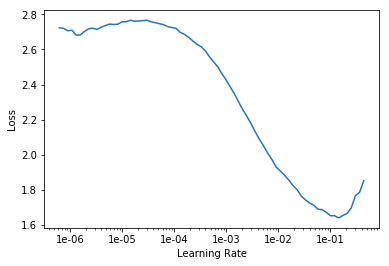

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.217199,0.138797,0.967400,00:21
1,0.121251,0.080577,0.980400,00:22
2,0.066456,0.041586,0.989200,00:22
3,0.032126,0.024480,0.992100,00:22
4,0.021867,0.015986,0.995100,00:22


### Results
Dig into the results by looking at the confusion matrix and plotting top losses.

In [17]:
preds, targs, losses = learn.get_preds(with_loss=True)

In [18]:
interp = ClassificationInterpretation(learn, preds, targs, losses)

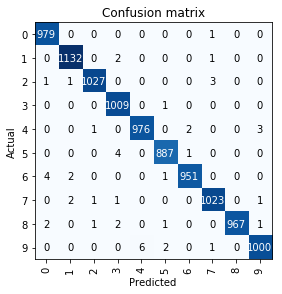

In [19]:
interp.plot_confusion_matrix()

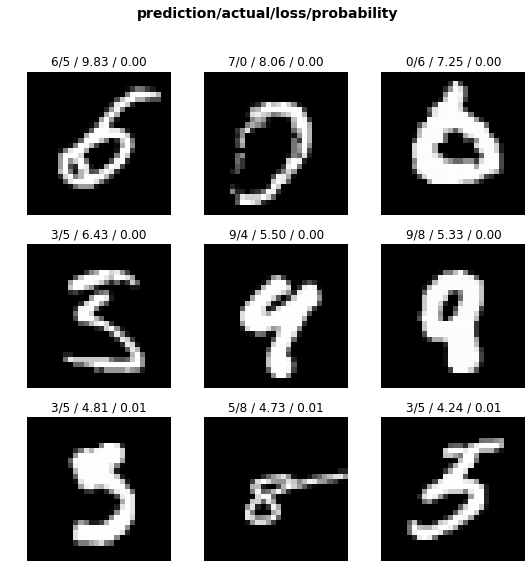

In [20]:
interp.plot_top_losses(9, figsize=(9, 9))

In [21]:
interp.most_confused(2)

[('9', '4', 6),
 ('5', '3', 4),
 ('6', '0', 4),
 ('2', '7', 3),
 ('4', '9', 3),
 ('1', '3', 2),
 ('4', '6', 2),
 ('6', '1', 2),
 ('7', '1', 2),
 ('8', '0', 2),
 ('8', '3', 2),
 ('9', '5', 2)]

In [22]:
# total number of incorrect predictions
int(torch.sum(interp.pred_class != interp.y_true))

49